## Finding Your Way In The City (Graph Edition)
In this notebook your attention will shift from grids to graphs. At least for search ... 

Using Voronoi graphs and the medial axis transform we can find paths which maximize safety from obstacles. In addition, graph representation allows further optimizations and more succinct queries.

In [14]:
# OK this might look a little ugly but...
# need to import the latest version of networkx
# This occassionally fails, so if the next cell 
# doesn't show that you're using networkx 2.1
# please "restart and clear output" from "Kernel" menu
# above and try again.
import sys
!{sys.executable} -m pip install -I networkx==2.1
# import pkg_resources
# pkg_resources.require("networkx==2.1")

  Using cached https://files.pythonhosted.org/packages/f1/cd/7c8240007e9716b14679bc217a1baefa4432aa30394f7e2ec40a52b1a708/decorator-4.3.2-py2.py3-none-any.whl


In [15]:
import networkx as nx
nx.__version__

'2.1'

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from grid import create_grid_and_edges
import numpy.linalg as LA
%matplotlib inline 

In [17]:
plt.rcParams['figure.figsize'] = 12, 12

In [18]:
# This is the same obstacle data from the previous lesson.
filename = 'colliders.csv'
data = np.loadtxt(filename, delimiter=',', dtype='Float64', skiprows=2)
print(data)

[[-310.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-300.2389   -439.2315     85.5         5.          5.         85.5     ]
 [-290.2389   -439.2315     85.5         5.          5.         85.5     ]
 ...
 [ 257.8061    425.1645      1.75852     1.292725    1.292725    1.944791]
 [ 293.9967    368.3391      3.557666    1.129456    1.129456    3.667319]
 [ 281.5162    354.4156      4.999351    1.053772    1.053772    4.950246]]


Starting and goal positions in *(north, east)*.

In [19]:
start_ne = (25,  100)
goal_ne = (750., 370.)

In [20]:
# Static drone altitude (metres)
drone_altitude = 5
safety_distance = 3

In [21]:
# This is now the routine using Voronoi
grid, edges = create_grid_and_edges(data, drone_altitude, safety_distance)
print(len(edges))

1895


Plot the edges on top of the grid along with start and goal locations.

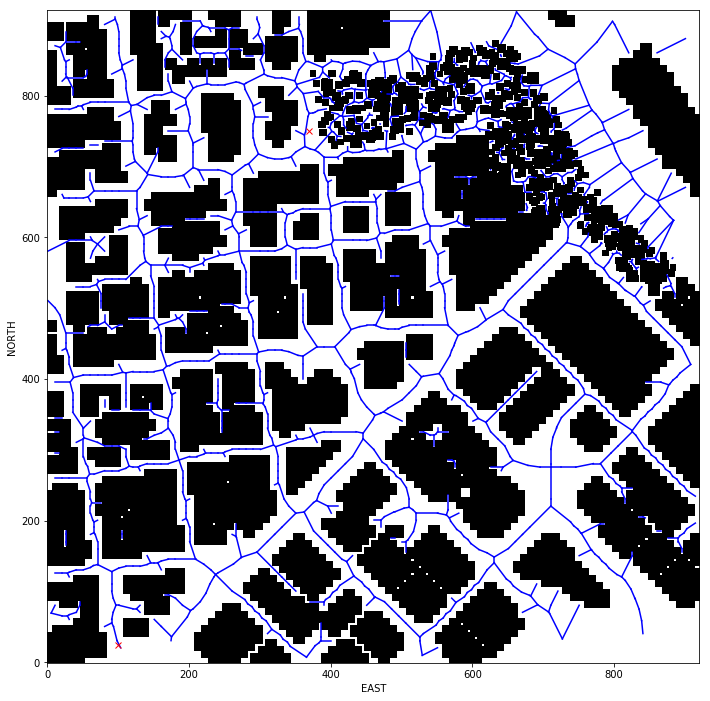

In [22]:
# equivalent to
# plt.imshow(np.flip(grid, 0))
plt.imshow(grid, origin='lower', cmap='Greys') 

for e in edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')

    
plt.plot(start_ne[1], start_ne[0], 'rx')
plt.plot(goal_ne[1], goal_ne[0], 'rx')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()

We now have a graph, well at least visually. The next step is to use the [`networkx`](https://networkx.github.io) to create the graph. **NetworkX** is a popular library handling anything and everything related to graph data structures and algorithms.

**NOTE:** In the initial import above it was imported with the `nx` alias.

You're encouraged to read the documentation but here's a super quick tour:

1. Create a graph:

```
G = nx.Graph()
```

2. Add an edge:

```
p1 = (10, 2.2)
p2 = (50, 40)
G = nx.add_edge(p1, p2)
```

3 Add an edge with a weight:

```
p1 = (10, 2.2)
p2 = (50, 40)
dist = LA.norm(np.array(p2) - np.array(p1))
G = nx.add_edge(p1, p2, weight=dist)
```

In [23]:
# TODO: create the graph with the weight of the edges
# set to the Euclidean distance between the points
G = nx.Graph()

In [24]:
for e in edges:
    p1, p2 = e
    dist = LA.norm(np.array(p2) - np.array(p1))
    G.add_edge(p1, p2, weight=dist)

You need a method to search the graph, and you'll adapt A* in order to do this. The notable differences being the actions are now the outgoing edges and the cost of an action is that weight of that edge.

In [25]:
h = LA.norm(np.array((3,4)) - np.array((1,2)))
h

2.8284271247461903

In [26]:
from queue import PriorityQueue

def heuristic(n1, n2):
    #TODO: define a heuristic
    h = LA.norm(np.array(n2) - np.array(n1))
    return h

###### THIS IS YOUR OLD GRID-BASED A* IMPLEMENTATION #######
###### With a few minor modifications it can work with graphs! ####
#TODO: modify A* to work with a graph
def a_star(grid, h, start, goal):

    path = []
    path_cost = 0
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_node = item[1]
        if current_node == start:
            current_cost = 0.0
        else:              
            current_cost = branch[current_node][0]
            
        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for action in valid_actions(grid, current_node):
                # get the tuple representation
                da = action.delta
                next_node = (current_node[0] + da[0], current_node[1] + da[1])
                branch_cost = current_cost + action.cost
                queue_cost = branch_cost + h(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    branch[next_node] = (branch_cost, current_node, action)
                    queue.put((queue_cost, next_node))
             
    if found:
        # retrace steps
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
    else:
        print('**********************')
        print('Failed to find a path!')
        print('**********************') 
    return path[::-1], path_cost


### Solution

This solution consists of two parts:

1. Find the closest point in the graph to our current location, same thing for the goal location.
2. Compute the path from the two points in the graph using the A* algorithm.
3. Feel free to use any of the path pruning techniques to make the path even smaller! 
4. Plot it up to see the results!

### TODO: Write your solution!

[our solution](/notebooks/Graph-Search-Solution.ipynb)

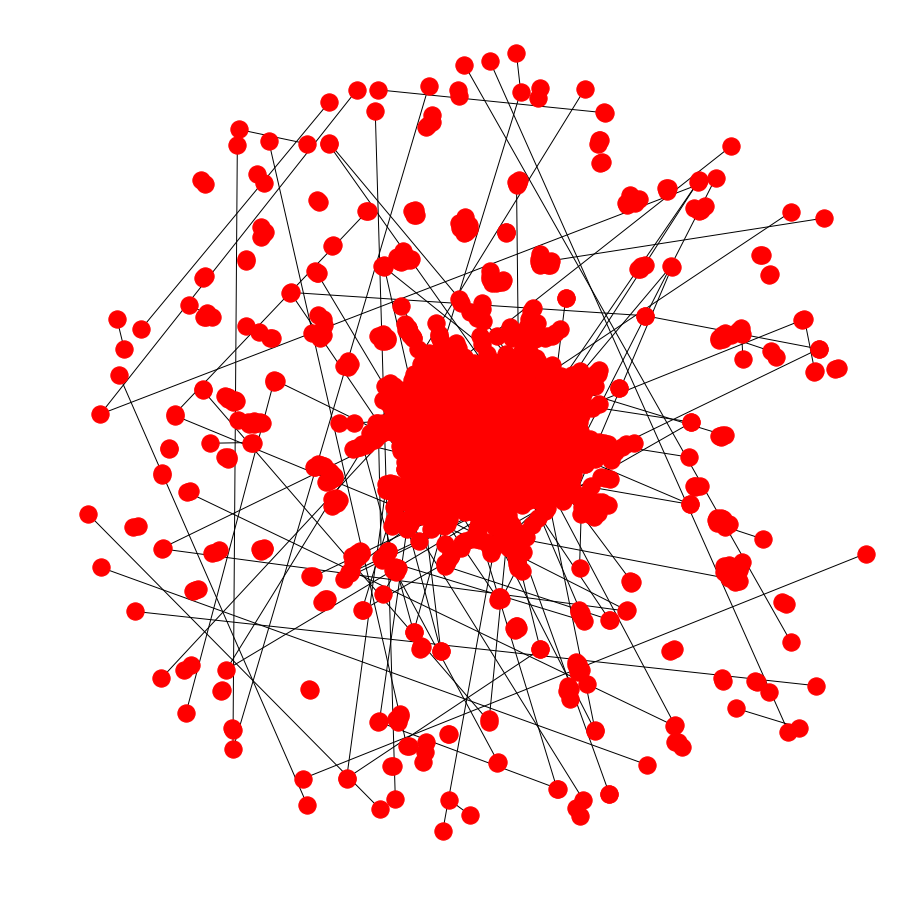

In [37]:
# list(G.edges)
nx.draw(G)

In [38]:
list(G.nodes)

[(860.7611, 860.7685),
 (880.7611, 900.7685),
 (905.1728647058824, 797.8273235294118),
 (875.7611, 775.7685),
 (845.0918815402507, 745.0992815402507),
 (853.9736449114224, 730.7685),
 (865.8633343429295, 706.6846606427216),
 (882.8093899455806, 692.8167899455806),
 (420.76110928574616, 908.2684766071934),
 (445.7612000002501, 895.7683999997499),
 (402.98335209876984, 888.5462879012302),
 (398.5388572838606, 882.9906738270885),
 (392.98336222222224, 878.5462777777778),
 (810.7611, 205.7685000000001),
 (820.7611000000002, 200.7685),
 (813.2611, 210.7685),
 (580.7610999999999, 135.76850000000002),
 (570.7610999999999, 137.43516666666667),
 (732.8165084735704, 798.6639959940788),
 (711.4274206664871, 747.5306910571946),
 (732.3876749290188, 799.0216498580377),
 (725.7351543230402, 801.0131533373633),
 (408.53888790123017, 892.9907120987698),
 (455.7611, 885.7685),
 (842.7968063755131, 456.3713451181708),
 (848.3357306737652, 440.76846785),
 (848.2502360079875, 467.0239054932102),
 (860.761

In [39]:
list(G.edges)

[((860.7611, 860.7685), (880.7611, 900.7685)),
 ((905.1728647058824, 797.8273235294118), (875.7611, 775.7685)),
 ((905.1728647058824, 797.8273235294118), (900.7611, 800.7685)),
 ((875.7611, 775.7685), (845.0918815402507, 745.0992815402507)),
 ((845.0918815402507, 745.0992815402507), (853.9736449114224, 730.7685)),
 ((845.0918815402507, 745.0992815402507),
  (838.1402075043337, 745.6423901902941)),
 ((853.9736449114224, 730.7685), (865.8633343429295, 706.6846606427216)),
 ((865.8633343429295, 706.6846606427216),
  (882.8093899455806, 692.8167899455806)),
 ((865.8633343429295, 706.6846606427216),
  (856.3899074848722, 694.8104375247049)),
 ((882.8093899455806, 692.8167899455806),
  (887.0257980745135, 687.8909684289295)),
 ((420.76110928574616, 908.2684766071934),
  (445.7612000002501, 895.7683999997499)),
 ((420.76110928574616, 908.2684766071934),
  (408.53888790123017, 892.9907120987698)),
 ((445.7612000002501, 895.7683999997499), (455.7611, 885.7685)),
 ((402.98335209876984, 888.54628

In [78]:
for node in G.edges:
    print(node)

((860.7611, 860.7685), (880.7611, 900.7685))
((905.1728647058824, 797.8273235294118), (875.7611, 775.7685))
((905.1728647058824, 797.8273235294118), (900.7611, 800.7685))
((875.7611, 775.7685), (845.0918815402507, 745.0992815402507))
((845.0918815402507, 745.0992815402507), (853.9736449114224, 730.7685))
((845.0918815402507, 745.0992815402507), (838.1402075043337, 745.6423901902941))
((853.9736449114224, 730.7685), (865.8633343429295, 706.6846606427216))
((865.8633343429295, 706.6846606427216), (882.8093899455806, 692.8167899455806))
((865.8633343429295, 706.6846606427216), (856.3899074848722, 694.8104375247049))
((882.8093899455806, 692.8167899455806), (887.0257980745135, 687.8909684289295))
((420.76110928574616, 908.2684766071934), (445.7612000002501, 895.7683999997499))
((420.76110928574616, 908.2684766071934), (408.53888790123017, 892.9907120987698))
((445.7612000002501, 895.7683999997499), (455.7611, 885.7685))
((402.98335209876984, 888.5462879012302), (398.5388572838606, 882.9906

((504.45813965372247, 841.4199801731388), (507.29882658289966, 837.3062265828997))
((504.45813965372247, 841.4199801731388), (510.3845580288314, 850.9516634578662))
((507.29882658289966, 837.3062265828997), (517.1182028693834, 829.4811254040044))
((569.2373746006788, 859.5977844856282), (566.1650877970584, 863.0331367586901))
((517.1182028693834, 829.4811254040044), (530.2661927451658, 839.034210162436))
((517.1182028693834, 829.4811254040044), (517.6764713954924, 827.6838713954924))
((530.2661927451658, 839.034210162436), (530.2878413604471, 839.0769404455241))
((517.6764713954924, 827.6838713954924), (524.9389510639443, 816.8037502666606))
((524.9389510639443, 816.8037502666606), (525.5629660505845, 815.5703660505844))
((543.7247246842536, 793.7321246842537), (554.1538332379573, 786.6713368976177))
((543.7247246842536, 793.7321246842537), (536.6270926163879, 803.9406352942459))
((554.1538332379573, 786.6713368976177), (555.4979627965604, 785.5053627965605))
((558.0232095723475, 834.4

In [45]:
np.array(G.node).shape

(1965, 2)

In [53]:
n_array = np.array(G.node)
index = np.argmin(np.linalg.norm(np.array(G.node) - np.array(goal_ne), axis=1))
print(goal_ne,tuple(n_array[index]))

(750.0, 370.0) (748.7187188843021, 364.4144680930903)


In [56]:
# find closest point from graph to the current location and goal location
# n = node
def find_closest(pt):
    n_array = np.array(G.node)
    n_index = np.argmin(np.linalg.norm(n_array - np.array(pt), axis=1))
    closest_pt_tuple = tuple(n_array[n_index])
    return closest_pt_tuple

In [57]:
# define heuristic function for graph A*
# manhattan does not make sense as it calculate grid traversal cost along x then y dir st. line
# but in graph you just go along edge which may or may not be along the axes
def heuristic(n1, n2):
    #TODO: define a heuristic
    h = LA.norm(np.array(n2) - np.array(n1))
    return h


In [88]:
start_gr = find_closest(start_ne)
goal_gr = find_closest(goal_ne)
print(start_gr, goal_gr)

(20.7611, 103.26850000000002) (748.7187188843021, 364.4144680930903)


In [59]:
print(heuristic(start_ne, goal_ne), heuristic(start_gr, goal_gr))

773.6439749652291 773.381866572381


In [64]:
?G.adj

In [72]:
goal_close = find_closest(goal_ne)
# print(G.adj[goal_close])
# print(G[goal_close].data('weight'))
for nbr_n, data_dict in G.adj[goal_close].items():
    print(nbr_n, data_dict['weight'])

(744.7377793378791, 362.81520951115954) 4.2901640626150375
(770.7610999999999, 367.81847242432417) 22.303672584055096


In [79]:
from queue import PriorityQueue

# grid based A*
def a_star_graph(graph, h, start, goal):
    path = []
    path_cost = 0
    queue = PriorityQueue()
    queue.put((0, start))
    visited = set(start)

    branch = {}
    found = False
    
    while not queue.empty():
        item = queue.get()
        current_node = item[1]
        if current_node == start:
            current_cost = 0.0
        else:              
            current_cost = branch[current_node][0]
            
        if current_node == goal:        
            print('Found a path.')
            found = True
            break
        else:
            for nbr_n, data_dict in graph.adj[current_node].items():
                action_edge = (tuple(current_node), tuple(nbr_n))
                next_node = nbr_n
                action_cost = data_dict['weight']
                branch_cost = current_cost + action_cost
                queue_cost = branch_cost + h(next_node, goal)
                
                if next_node not in visited:                
                    visited.add(next_node)               
                    branch[next_node] = (branch_cost, current_node, action_edge)
                    queue.put((queue_cost, next_node))
             
    if found:
        # retrace steps
        n = goal
        path_cost = branch[n][0]
        path.append(goal)
        while branch[n][1] != start:
            path.append(branch[n][1])
            n = branch[n][1]
        path.append(branch[n][1])
    else:
        print('**********************')
        print('Failed to find a path!')
        print('**********************') 
    return path[::-1], path_cost


In [80]:
path, path_cost = a_star_graph(G, heuristic, start_gr, goal_gr)

Found a path.


In [83]:
print(len(path), path_cost)

97 1050.2941022437396


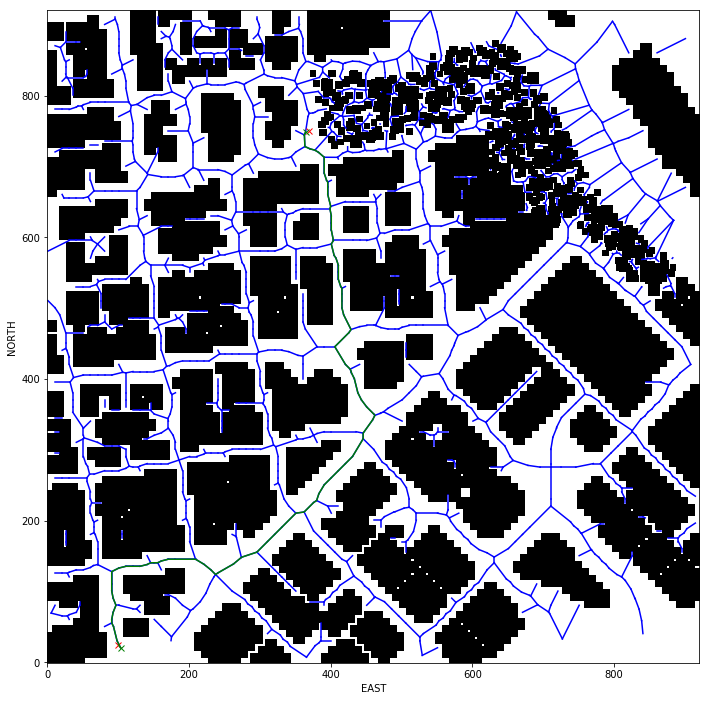

In [87]:
plt.imshow(grid, origin='lower', cmap='Greys') 

for e in G.edges:
    p1 = e[0]
    p2 = e[1]
    plt.plot([p1[1], p2[1]], [p1[0], p2[0]], 'b-')

    
plt.plot(start_ne[1], start_ne[0], 'rx')
plt.plot(goal_ne[1], goal_ne[0], 'rx')

plt.plot(start_gr[1], start_gr[0], 'gx')
plt.plot(goal_gr[1], goal_gr[0], 'gx')

pp = np.array(path)
plt.plot(pp[:, 1], pp[:, 0], 'g')

plt.xlabel('EAST')
plt.ylabel('NORTH')
plt.show()